In [119]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Load data into dataframe and understand dimensions

In [62]:
dataset = xr.open_dataset('data/processed/neuropixels/steinmetz_2016-12-14_Cori.nc')
wheel_data = dataset.wheel.to_dataframe().reset_index()
wheel_data

,mouse,session_date,trial,time,wheel
0,Cori,2016-12-14,1,0.01,-1
1,Cori,2016-12-14,1,0.02,0
2,Cori,2016-12-14,1,0.03,0
3,Cori,2016-12-14,1,0.04,0
4,Cori,2016-12-14,1,0.05,0
...,...,...,...,...,...
90995,Cori,2016-12-14,364,2.46,0
90996,Cori,2016-12-14,364,2.47,0
90997,Cori,2016-12-14,364,2.48,0
90998,Cori,2016-12-14,364,2.49,0


Each row of the above dataframe contains a single point in time for all trials. 

Lets make a list of arrays of wheel speed for each trial and a list of trial numbers

In [63]:
wheel_list = [group.wheel.values for group_name,group in   wheel_data.groupby("trial")]
trial_list = [group_name for group_name,group in   wheel_data.groupby("trial")]

Now convert this list of arrays into a dataframe where each column represents a trial an the time bins are given by the index

In [163]:
wheel_df = pd.DataFrame({trial_list[i]: wheel_list[i] for i in range(len(trial_list))})
wheel_df.index.name = 'time_bin'
wheel_df

,1,2,3,4,5,6,7,8,9,10,...,355,356,357,358,359,360,361,362,363,364
time_bin,,,,,,,,,,,,,,,,,,,,,
0,-1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,-1,0,0,-1,0,0,1,0,...,0,0,0,1,-1,0,0,0,0,0
3,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,-7,1,0,0,0,0,...,0,0,0,-1,0,0,0,1,0,0
246,0,0,0,0,-6,2,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
247,1,1,-1,0,-6,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualise wheel speed

Text(0.5, 0, 'time bin')

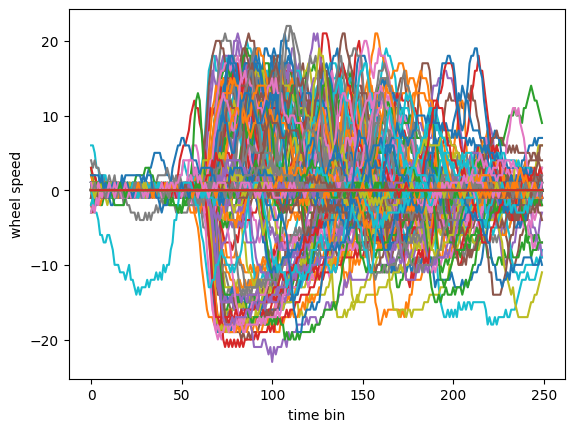

In [65]:
plt.plot(wheel_df);

plt.ylabel("wheel speed")
plt.xlabel("time bin")



Looks overplotted!

Now make a plot where each pixel represents the density of lines in the above plot. 

Start with plotting just one trial

Text(0, 0.5, 'wheel speed/arb. units')

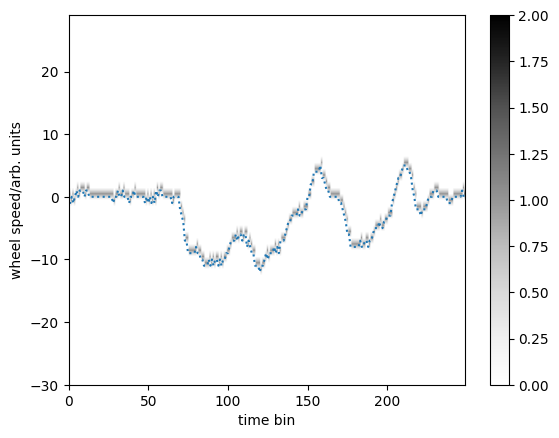

In [158]:
y_bins = np.arange(-30,30,1)
x_bins= wheel_df.index.values

h, _xx, _yy = np.histogram2d(wheel_df[2],wheel_df.index.values, bins=[ y_bins,x_bins])
heatmap_matrix = h

im = plt.imshow(heatmap_matrix,  
                cmap=plt.cm.Greys,
                interpolation='bilinear',
                aspect='auto',
                origin="lower",
                extent=[min(x_bins),max(x_bins),min(y_bins),max(y_bins)])

plt.colorbar(im) # show heatmap
plt.plot(wheel_df[2], ":") # overplot data as sanity check

plt.xlabel("time bin")
plt.ylabel("wheel speed/arb. units")

Now plot all trials in the dataframe


Text(0, 0.5, 'wheel speed/arb. units')

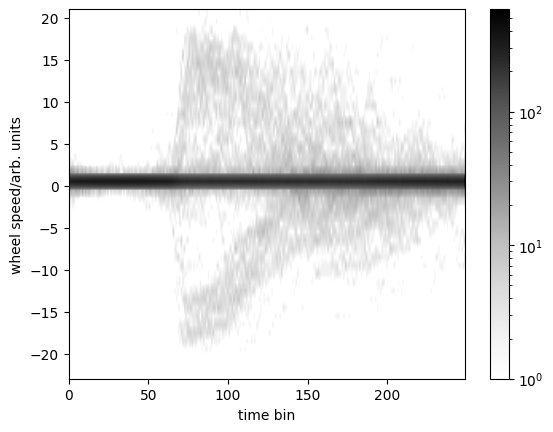

In [310]:
y_bins = np.arange(wheel_df.min(axis=None), wheel_df.max(axis=None),1)
x_bins= wheel_df.index.values

heatmap_matrix = np.zeros([ len(y_bins[:-1]),len(x_bins[:-1])])

for i, col in wheel_df.items():
    h,xx,yy = np.histogram2d(col,wheel_df.index.values, bins=[ y_bins,x_bins])
    heatmap_matrix += h

im = plt.imshow(heatmap_matrix, 
                norm=LogNorm(), 
                cmap=plt.cm.Greys,
                interpolation='bilinear',
                aspect='auto',
                origin="lower",
                extent=[min(x_bins),max(x_bins),min(y_bins),max(y_bins)] )
plt.colorbar(im)

plt.xlabel("time bin")
plt.ylabel("wheel speed/arb. units")

# Determine how much the wheel must be moved for a reward

Find out how much the mouse has to turn the wheel in the correct direction to complete the task



In [285]:
df= dataset[['response_type', 'response_time', 'active_trials', 'gocue', 'stim_onset',"feedback_type", "contrast_left", "contrast_right"]].to_dataframe().reset_index()

# get active trials where feedback was positive and wheel was turned
dir_df = df[ (df["active_trials"]==True)& (df["feedback_type"]==1) & (df["response_type"]!=0) ].copy()

# get time bin values of response time and gocue
time_bin_val_s = 10e-3
dir_df["response_time_bin"] = (round(dir_df["response_time"] / time_bin_val_s)).astype(int)
dir_df["gocue_time_bin"] = (round(dir_df["gocue"] / time_bin_val_s)).astype(int)


Get trials where the response_type was 1 (ie. right turns) and isolate wheel speeds between gocue and response time

An integral of wheel speed in the interval between gocue and response time gives the wheel position.


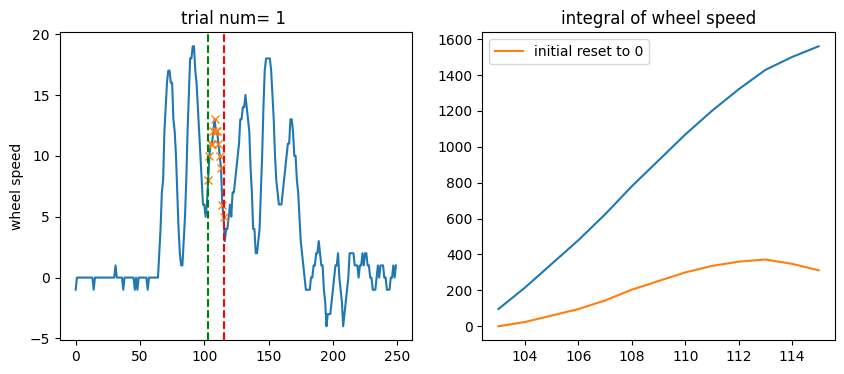

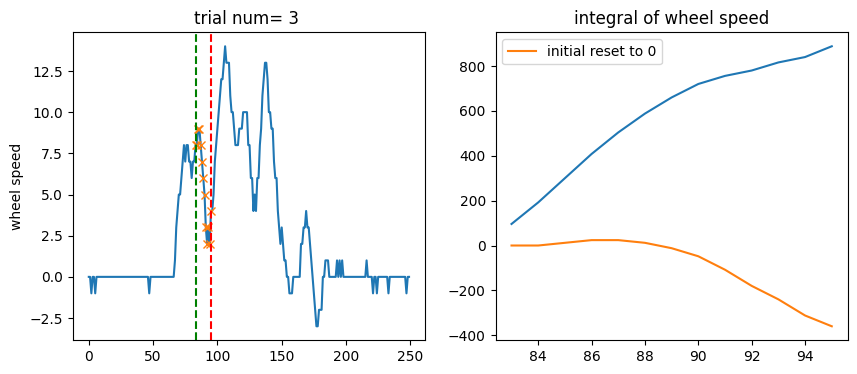

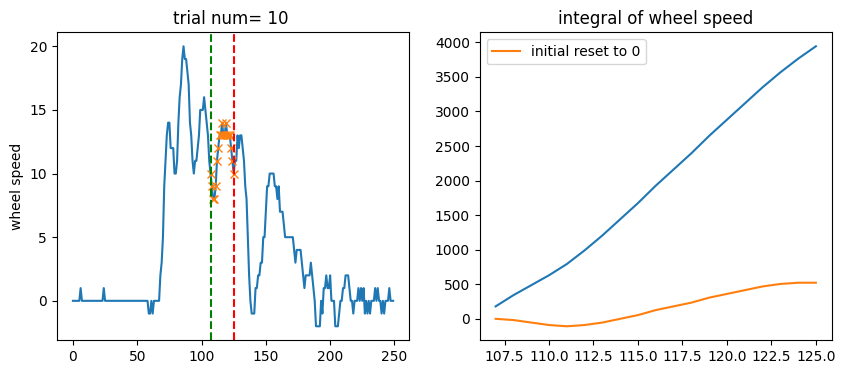

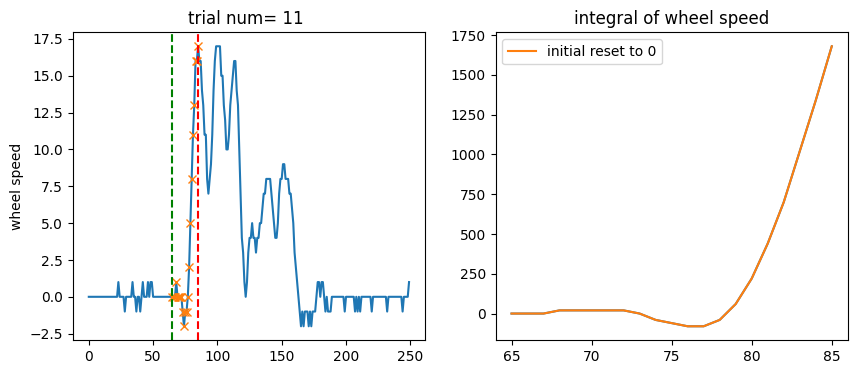

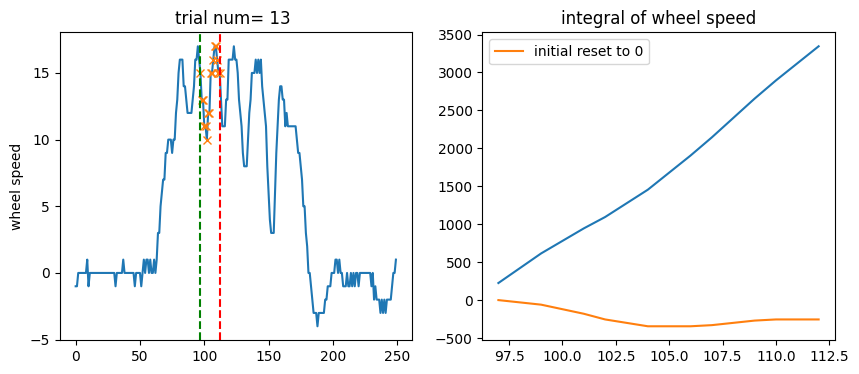

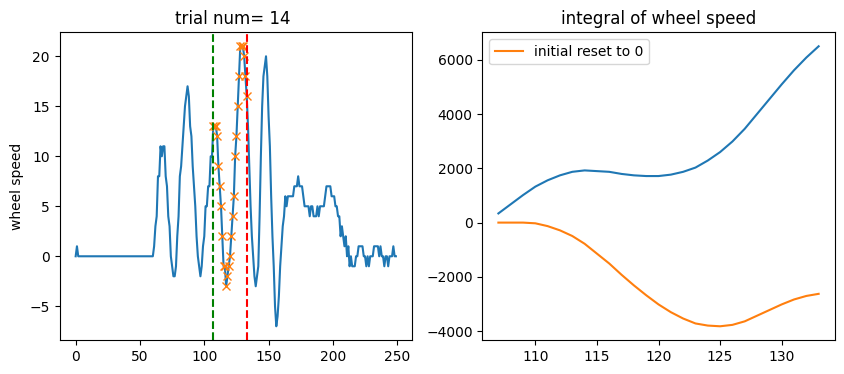

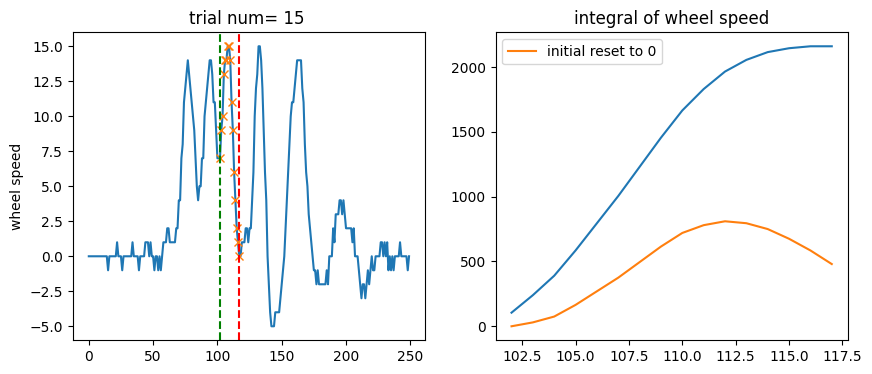

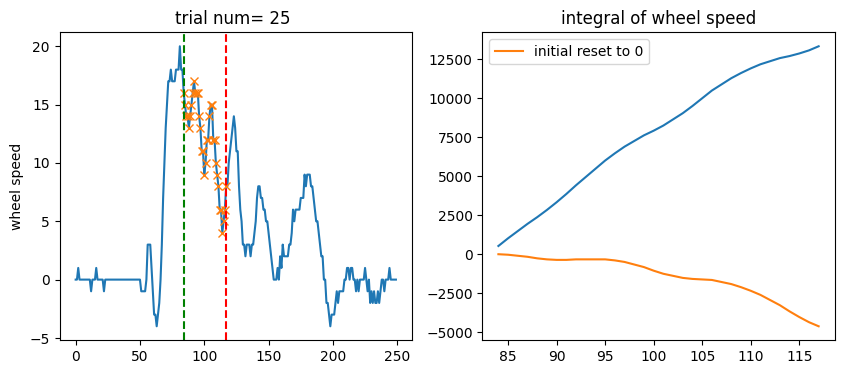

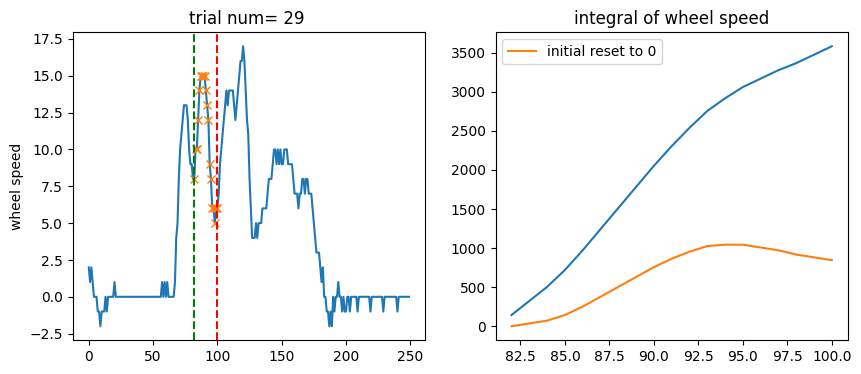

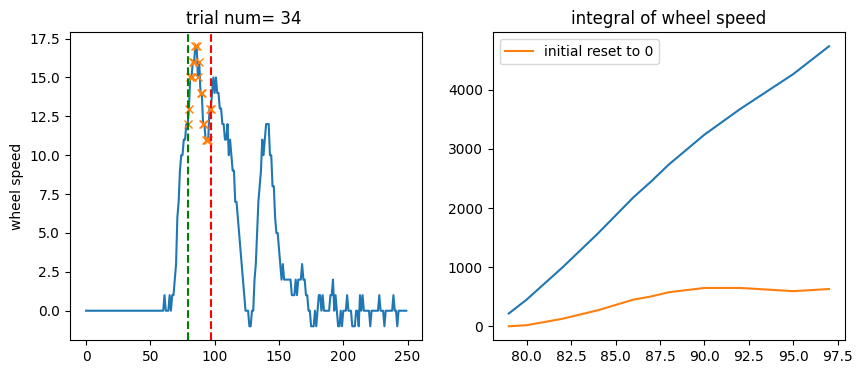

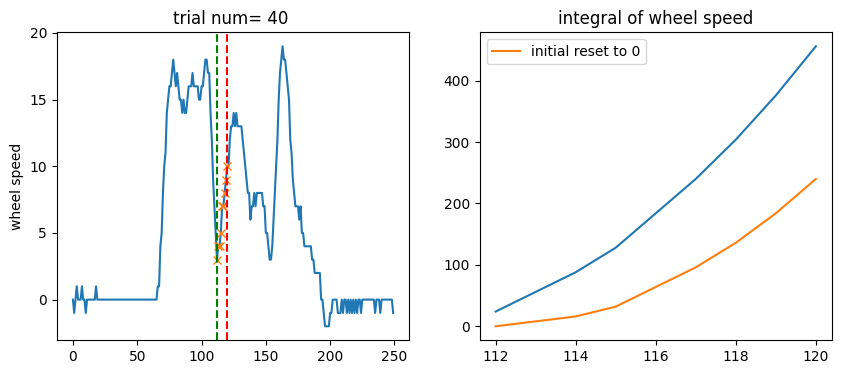

In [318]:
right_turn_trials = dir_df[dir_df["response_type"]==1]
trial_nums = right_turn_trials["trial"].values

gg = right_turn_trials["gocue_time_bin"].values
rr = right_turn_trials["response_time_bin"].values


for i, trial in enumerate(trial_nums):
    go_cue_bin = gg[i]
    response_bin = rr[i]
    
    wheel_response =wheel_df.loc[go_cue_bin:response_bin ,trial]

    fig,axs = plt.subplots(1,2, figsize=(10,4))
    ax=axs[0]
    ax.plot(wheel_df[trial])
    ax.plot(wheel_response,"x")
    ax.axvline(go_cue_bin, c="g", ls="--")
    ax.axvline(response_bin, c="r", ls="--")
    ax.set_title("trial num= %s "%(trial))
    ax.set_ylabel("wheel speed")

    ax=axs[1]
    ax.plot(wheel_response.cumsum()* (response_bin - go_cue_bin)) # cumlative sum
    ax.plot((response_bin - go_cue_bin)*(wheel_response - wheel_response.iloc[0]).cumsum(), label="initial reset to 0") # cumulative sum with start position reset to 0
    ax.set_title("integral of wheel speed")
    ax.legend()
    plt.show()
    if i >9: break # for testing 

OK, that is not making a lot of sense. There seems to be no integrated wheel speed value that is shared across the selected trials.

Perhaps the wheel speed data is normalised individually for each trial?

The distribution of integrated wheel position over response period is very wide!

Text(0, 0.5, 'count')

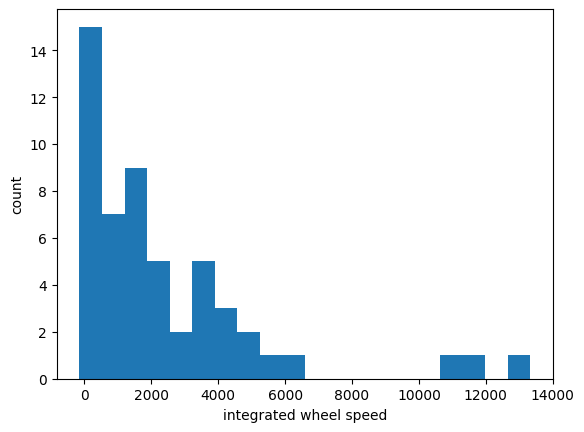

In [316]:
right_turn_trials = dir_df[dir_df["response_type"]==1]
trial_nums = right_turn_trials["trial"].values

gg = right_turn_trials["gocue_time_bin"].values
rr = right_turn_trials["response_time_bin"].values

sum=[]
for i, trial in enumerate(trial_nums):
    go_cue_bin = gg[i]
    response_bin = rr[i]
    
    wheel_response =wheel_df.loc[go_cue_bin:response_bin ,trial]
    sum.append( wheel_response.sum()* (response_bin - go_cue_bin))


plt.hist(sum,20)
plt.xlabel("integrated wheel speed")
plt.ylabel("count")

(-23, 22)